## Importing Libraries

In [3]:
from importlib import reload
import pandas as pd
import model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    BaggingRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor
)
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
reload(ms)

<module 'model_selection' from 'e:\\Ames-Housing-Price-Predictor\\notebooks\\model_selection.py'>

## Load dataset

In [4]:
df = pd.read_parquet('../data/processed/06_feature_selection.parquet')

In [5]:
x = df.drop(columns=['saleprice'])
y = df['saleprice']
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42,
)

## Model Training

In [6]:
models = {
    'Bagging Regressor': BaggingRegressor(),
    'Random Forest': RandomForestRegressor(n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(verbose=0),
    'CatBoost': CatBoostRegressor(task_type='GPU', devices='0', verbose=0),
    'LightGBM': LGBMRegressor(device='gpu', n_jobs=-1, verbose=-1),
    "XGBoost": XGBRegressor(tree_method="hist", device="cuda")
}

In [7]:
from scipy.stats import loguniform, randint

param_dist = {
    'Bagging Regressor': {
        'n_estimators': randint(10, 50),
        'max_samples':  [0.5, 0.75, 1.0],
        'max_features': [0.5, 0.75, 1.0]
    },
    'Random Forest': {
        'n_estimators':      randint(50, 100),
        'max_depth':         randint(5, 20),
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf':  [1, 2, 4],
        'max_features':      ['auto', 'sqrt']
    },
    'Gradient Boosting': {
        'n_estimators': randint(50, 100),
        'learning_rate': loguniform(1e-3, 0.5),
        'max_depth':     randint(3, 8),
        'subsample':     [0.6, 0.8, 1.0]
    },
    'CatBoost': {
        'iterations':   randint(100, 300),
        'learning_rate': loguniform(1e-3, 0.2),
        'depth':        randint(4, 8),
        'l2_leaf_reg':  [1, 3, 5, 10]
    },
    'LightGBM': {
        'n_estimators':     randint(50, 100),
        'learning_rate':    loguniform(1e-3, 0.5),
        'num_leaves':       [31, 50, 100],
        'min_child_samples':[5, 10, 20],
        'subsample':        [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators':     randint(50, 100),
        'learning_rate':    loguniform(1e-3, 0.5),
        'max_depth':        randint(3, 8),
        'subsample':        [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
}


In [ ]:
reload(ms)
models_pro = ms.regression_hyperparameter_tuning(x_train, y_train, models, param_dist, cv=2, n_iter = 50)

✅ Tuning hyperparameter for Bagging Regressor...


In [8]:
reload(ms)
regression_metrics, predictions_dict, importances_dict = ms.model_predict(models_pro, x_train, x_test, y_train, y_test)


✅ Testing Bagging Regressor...
MAE: 16434.383989993745 | MSE: 775897440.0321469 | RMSE: 27854.93564939878 | R²: 0.865622426353735 | RMSLE: 0.14514541465842717 | MAPE: 0.10294584223086306
--------------------------------------------------

✅ Testing Random Forest...
MAE: 15910.467084261394 | MSE: 703235079.6198959 | RMSE: 26518.579894479568 | R²: 0.8782068108146557 | RMSLE: 0.14644836235914177 | MAPE: 0.10227423923291663
--------------------------------------------------

✅ Testing Gradient Boosting...
MAE: 15058.376147755798 | MSE: 695620955.3102626 | RMSE: 26374.627112250564 | R²: 0.8795254999833262 | RMSLE: 0.13749015950991206 | MAPE: 0.09570910215527925
--------------------------------------------------

✅ Testing CatBoost...
MAE: 14610.536852732457 | MSE: 619037210.339982 | RMSE: 24880.458402931046 | R²: 0.8927890285102721 | RMSLE: 0.13225061476288888 | MAPE: 0.0923095462000113
--------------------------------------------------

✅ Testing LightGBM...
MAE: 14681.118477342054 | MSE:

## Model Evaluation

In [10]:
regression_metrics

,Model,MAE,MSE,RMSE,R²,RMSLE,MAPE
0,Bagging Regressor,16434.383990,7.758974e+08,27854.935649,0.865622,0.145145,0.102946
1,Random Forest,15910.467084,7.032351e+08,26518.579894,0.878207,0.146448,0.102274
2,Gradient Boosting,15058.376148,6.956210e+08,26374.627112,0.879525,0.137490,0.095709
3,CatBoost,14610.536853,6.190372e+08,24880.458403,0.892789,0.132251,0.092310
4,LightGBM,14681.118477,7.411180e+08,27223.482843,0.871646,0.136498,0.093745
5,XGBoost,14831.143102,7.097620e+08,26641.359680,0.877076,0.134253,0.093562


### Residuals Plot

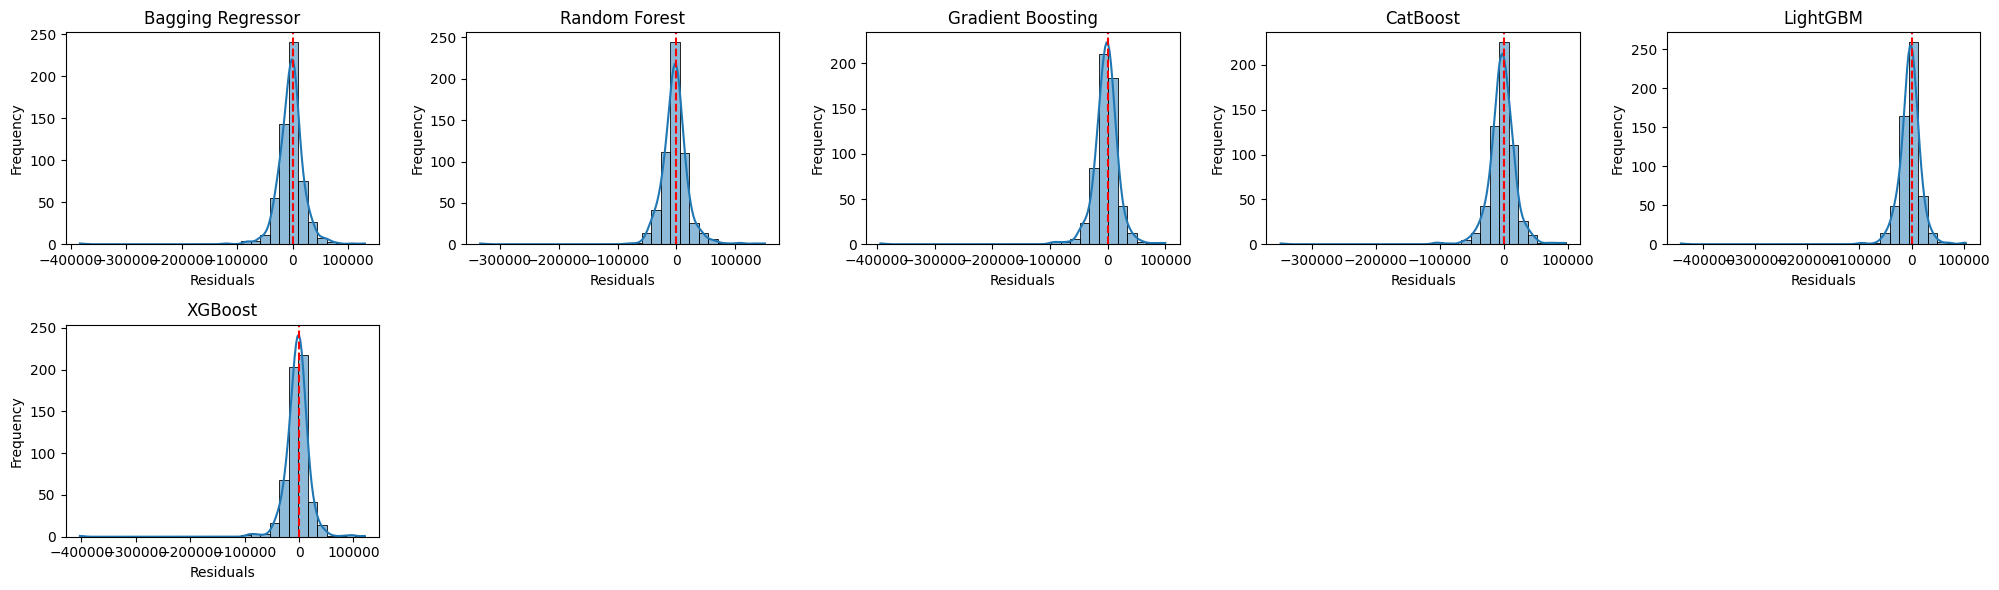

In [11]:
reload(ms)
ms.plot_residuals(y_test, predictions_dict, n_cols=5)

### Scatter Plot

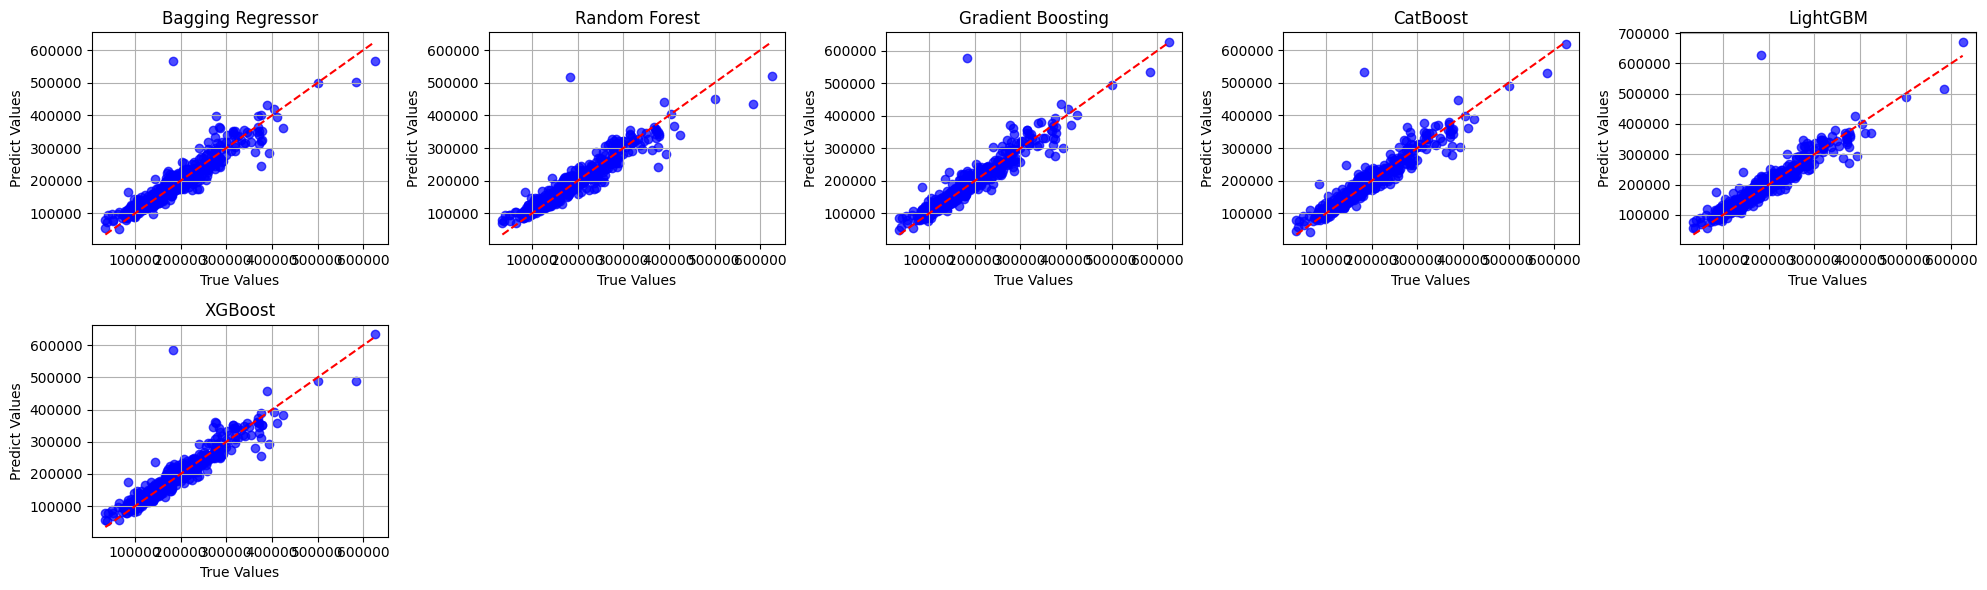

In [12]:
reload(ms)
ms.scatter_plot(y_test, predictions_dict, n_cols=5)

### Learning Curve

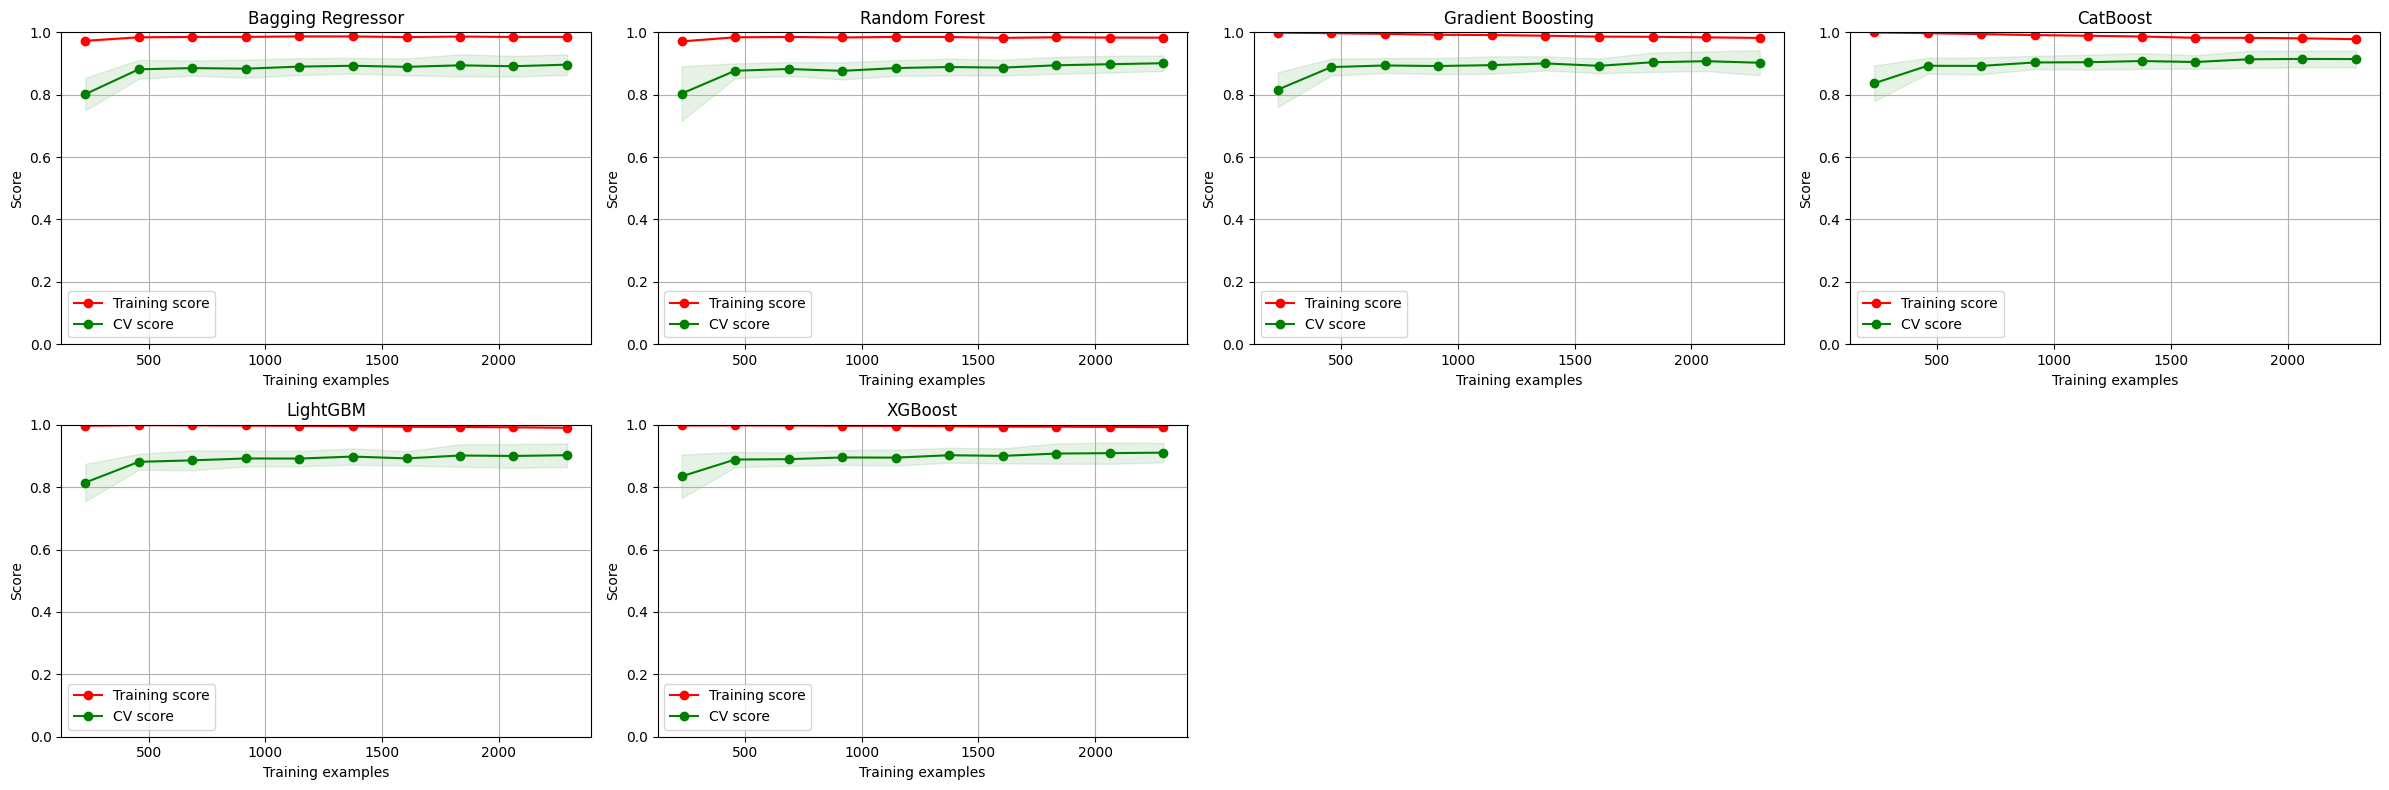

In [15]:
reload(ms)
learning_curve_summary = ms.learning_curves_regression(models_pro, x, y, cv=5, scoring='r2', cols=4)

### Learning Curve Summary

In [16]:
learning_curve_summary

,Model,Train score,CV score,Gap,Best n_samples
0,Bagging Regressor,0.985336,0.896367,0.088969,2293
1,Random Forest,0.983003,0.900988,0.082015,2293
2,Gradient Boosting,0.982131,0.902506,0.079625,2063
3,CatBoost,0.978130,0.914302,0.063829,2063
4,LightGBM,0.990634,0.902644,0.087989,2293
5,XGBoost,0.992525,0.910857,0.081668,2293


### Best Model

In [ ]:
models_pro['CatBoost'].save_model('../models/catboost_model_pro.cbm')